# [DeepLearning] [3] 파이토치 - 선형 회귀 모델

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 선형 회귀 모델

경사하강법을 이용하여 선형 회귀 모델을 구해보겠습니다. NBA 선수들의 키와 윙스팬 데이터를 활용하겠습니다.

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


In [6]:
draft_data = pd.read_csv('/content/drive/MyDrive/nba_draft.csv')

In [7]:
draft_data.head()

,player,height_no_shoes,height_with_shoes,wingspan,weight
0,Zach Collins,82.25,84.00,85.00,232.0
1,Luke Kennard,76.50,77.50,77.25,196.0
2,Donovan Mitchell,73.25,75.00,82.00,211.0
3,Bam Adebayo,80.75,81.75,86.75,243.0
4,Justin Patton,82.00,83.25,87.00,229.0


y축에 윙스팬, x축에 신발을 신지 않았을 때의 키를 둔 산점도를 그려보겠습니다.

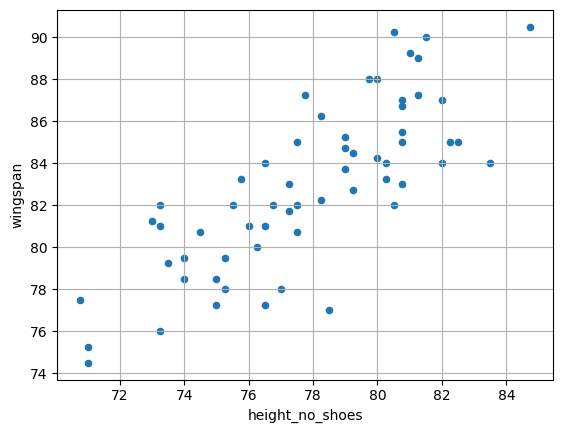

In [11]:
draft_data.plot.scatter('height_no_shoes','wingspan')
plt.grid()

선형 회귀 모델은 $F(m, b;x) = mx + b$이라고 할 때, $m$과 $b$ 값을 구하는 ordinary least squares 함수를 만들어보겠습니다.

$$m=\dfrac{\sum^{N}_{i=1}(x_i-\bar{x})(y_i-\bar{y})}{\sum^N_{i=1}(x_i-\bar{x})^2}$$

$$b=\bar{y}-m\cdot\bar{x}$$

In [16]:
def ordinary_least_squares(x,y):
    N = len(x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    m = ((x-mean_x)*(y-mean_y)).sum()/((x-mean_x)**2).sum()
    b = mean_y - m*mean_x
    return m, b

x값으로 윙스팬, y값으로 신발을 신지 않은 키 데이터를 넣고 $m$과 $b$값을 구해보겠습니다.

In [19]:
height = draft_data.height_no_shoes.values
wingspan = draft_data.wingspan.values
m,b = ordinary_least_squares(height,wingspan)

데이터의 산점도와 선형 회귀 예측선을 그려보겠습니다.

AttributeError: module 'matplotlib.pyplot' has no attribute 'gird'

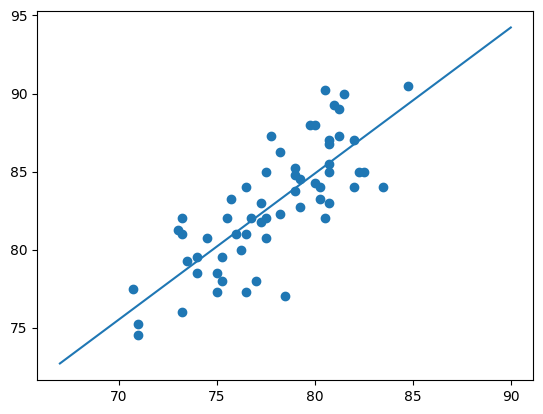

In [21]:
plt.scatter(height, wingspan)
x = np.linspace(67,90, 1000)
plt.plot(x , m*x+b)
plt.gird()

아래 함수는 $m$, $b$ 값들에 따른 $ℒ_{MSE}(m,b)$의 그래프와, $[m,b]$ 값들이 움직이는 경로(trajectory)에 따른 $ℒ_{MSE}(m,b)$의 변화를 표시해주는 graph_linear_regression_mse입니다. 최적의 $m$, $b$ 값에 대한 $ℒ_{MSE}(m,b)$ 값은 검은색 점으로 표시하고, $[m,b]$ 값에 대해 변화하는 각각의 $ℒ_{MSE}(m,b)$값들을 별 모양 점으로 표시함으로써, 우리가 입력해준 $[m, b]$ 값들의 경로가 최적의 값을 잘 찾아가는지 확인하는 데 사용할 수 있습니다.

In [22]:
def graph_linear_regression_mse(
    x,
    y,
    trajectory=None,
    m_scale=10,
    b_scale=10,
    sample_density=500,
):

    def mse(x, y, m, b):
        m = np.atleast_1d(m)
        b = np.atleast_1d(b)
        return ((x * m[None] + b[None] - y) ** 2).mean(axis=1)

    # 손실함수 MSE를 최소한으로 만드는 m, b값(m_opt, b_opt) 계산
    A = np.vstack([x, np.ones(len(x))]).T
    m_opt, b_opt = np.linalg.lstsq(A, y, rcond=None)[0]
    l_opt = mse(x, y, m_opt, b_opt)

    center_m = m_opt
    center_b = b_opt

    # MSE 그래프의 figure 생성
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # MSE 그래프의 최소점을 그래프 위에 검은 점으로 표시
    ax.plot(
        [m_opt],
        [b_opt],
        l_opt,
        c="black",
        marker="o",
        zorder=3,
        markersize=7,
    )

    # 그래프를 그리는 데 사용할 m, b값들을 추출하여 numpy 배열의 형태로 생성하고, 이들 값에 대응되는 MSE 값들을 계산
    m_series = np.linspace(center_m - m_scale, center_m + m_scale, sample_density)
    b_series = np.linspace(
        center_b - b_scale, center_b + b_scale, sample_density
    ).reshape(-1, 1)

    Z = (b_series + x.reshape(-1, 1, 1) * m_series) - y.reshape(-1, 1, 1)
    Z = np.mean(Z ** 2, axis=0)

    # 그래프 그리기
    m_series, b_series = np.meshgrid(m_series, b_series)
    ax.set_xlabel("Slope: m")
    ax.set_ylabel("Intercept: b")
    ax.set_zlabel("MSE Loss")
    ax.ticklabel_format(style="sci", scilimits=(-1, 2))
    ax.dist = 11
    surf = ax.plot_surface(m_series, b_series, Z, cmap=plt.get_cmap("GnBu"))

    # 지정한 trajectory를 그래프 위에 나타내기
    if trajectory is not None:
        trajectories = np.atleast_2d(trajectory)
        if trajectories.ndim == 2:
            trajectories = trajectories[np.newaxis]
        for trajectory in trajectories:
            m_values, b_values = trajectory.T
            l_values = ((x * m_values[:, None] + b_values[:, None] - y) ** 2).mean(
                axis=1
            )
            ax.plot(
                m_values,
                b_values,
                l_values,
                marker="*",
                c='red',
                zorder=3,
                markersize=7,
            )
    return fig, ax

위의 함수를 활용하여 NBA 데이터에 대한 $ℒ_{MSE}(m,b)$ 그래프를 그려보겠습니다. OLS로 구한 $[m^*, b^*]$값(출력된 결과 그래프에서 별표 표시)과 graph_linear_regression_mse()에서 계산한 m_opt, b_opt 값이 동일한지, 즉 이 두 점에서 MSE 값이 가장 작게 나타나는지 확인해보겠습니다.

<ipython-input-22-a488eb49ce51>:53: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='Slope: m', ylabel='Intercept: b', zlabel='MSE Loss'>)

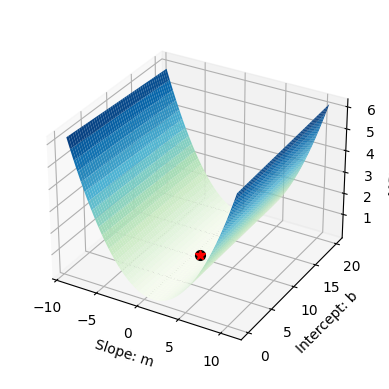

In [24]:
graph_linear_regression_mse(height, wingspan,trajectory = [m,b])

---

## 2. 경사하강법
  
경사하강법을 구현하는 함수 gradient_step를 구현해보겠습니다.

In [43]:
def gradient_step(tensors, learning_rate):
  if isinstance(tensors, torch.Tensor):
    tensors = [tensors]

  for t in tensors:
    if t.grad is not None :
        t.data -= learning_rate * t.grad
        t.grad.zero_()


손실함수로 사용할 모델이 예측한 값과 실제로 관측된 값 사이의 MSE 값을 계산하는 함수 mean_squared_error를 구현해보겠습니다.

$$MSE=\dfrac{1}{n}\sum^n_{i=1}(y_i-\hat{y_i})^2$$

In [26]:
def mean_squared_error(y_true, y_pred):
    mse = torch.mean((y_pred - y_true)**2)
    return mse

### 2.1. 선형 모델 클래스

선형 모델의 모델 파라미터 $m$, $b$를 관리하고 모델을 이용한 예측값을 계산하는 과정을 캡슐화하기 위해, LinearModel이라는 클래스를 생성하겠습니다.

In [35]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.m = nn.Parameter(torch.empty(1))
        self.b = nn.Parameter(torch.empty(1))

        nn.init.uniform_(self.m, -10, 10)
        nn.init.uniform_(self.b, -10, 10)

    def forward(self, x):
      return self.m * x + self.b

    @property
    def parameters(self):
      return (self.m, self.b)

> * 매서드 호출 방식
> ```python
    model = LinearModel()
    params = model.parameters()
    
> * 속성 접근 방식
> ```python
    model = LinearModel()
    params = model.parameters  


### 2.2. 경사하강법을 통한 모델 학습
적합한 선형 회귀 모델을 찾기 위해 경사하강법을 시행해보겠습니다. x, y값, 모델, 경사하강법을 통해 구해질 모델 파라미터를 저장할 배열, epoch, learning rate를 설정하겠습니다.

In [36]:
height_torch = torch.tensor(height, dtype =  torch.float32)
wingspan_torch = torch.tensor(wingspan, dtype = torch.float32)
model = LinearModel()

trajectory = []

num_epochs = 10
learning_rate = 1e-4

경사하강법으로 선형 회귀 모델을 학습시켜보겠습니다. 손실값, 기울기, 절편을 저장하면서 epoch마다 손실값이 어떻게 변화하는지 출력해보겠습니다.

In [44]:
loss_values = []
m_values = []
b_values = []

for epoch in range(num_epochs):
    y_pred = model(height_torch)

    loss = mean_squared_error(wingspan_torch, y_pred)
    loss.backward()

    trajectory.append((model.m.item(), model.b.item()))

    gradient_step(model.parameters, learning_rate)

    loss_values.append(loss.detach().clone().numpy())
    m_values.append(model.m.detach().clone().numpy())
    b_values.append(model.b.detach().clone().numpy())

    print(f'Epoch {epoch + 1}')
    print(f'Loss: {loss}')

Epoch 1
Loss: 215629.9375
Epoch 2
Loss: 9921.87109375
Epoch 3
Loss: 462.2247314453125
Epoch 4
Loss: 27.215106964111328
Epoch 5
Loss: 7.210911273956299
Epoch 6
Loss: 6.290991306304932
Epoch 7
Loss: 6.248688697814941
Epoch 8
Loss: 6.2467427253723145
Epoch 9
Loss: 6.246650695800781
Epoch 10
Loss: 6.24664831161499


loss, m, b 그래프를 그려보겠습니다.

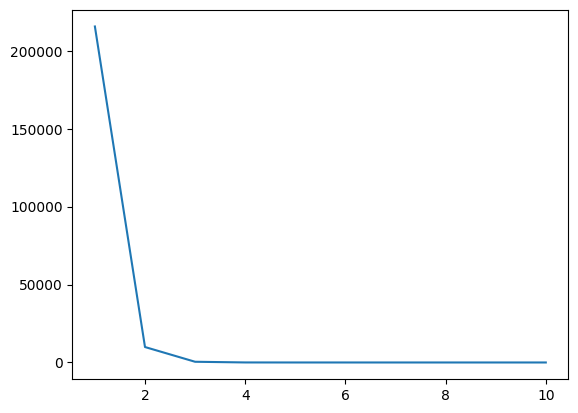

In [45]:
plt.plot(range(1, 11), loss_values)


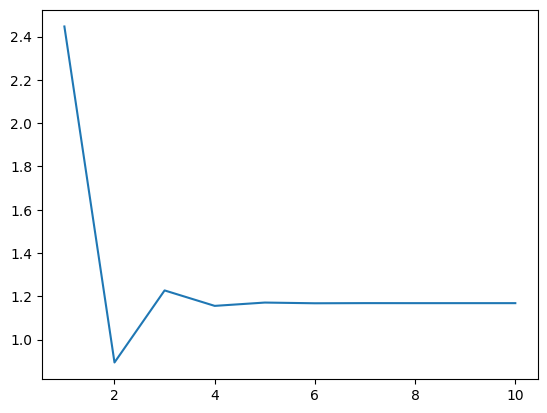

In [46]:
plt.plot(range(1, 11), m_values)

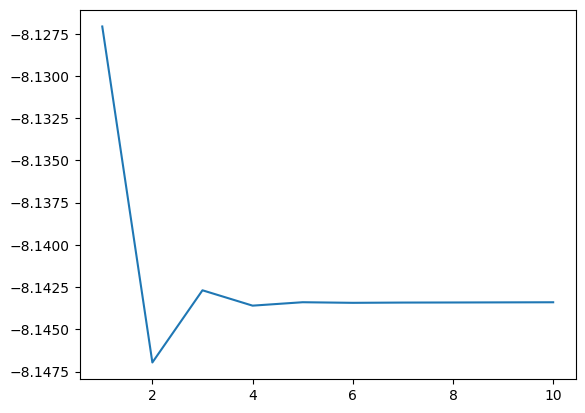

In [47]:
plt.plot(range(1, 11), b_values)

> 스텝을 거듭할수록 손실함수 값이 0에 가까워지고, 두 모델 파라미터 값이 하나의 값에 수렴하는 형태가 보입니다.

graph_linear_regression_mse를 통해 loss landscape 상에서 손실함수 값이 어떻게 변화해갔는지 확인해보겠습니다.

<ipython-input-22-a488eb49ce51>:53: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='Slope: m', ylabel='Intercept: b', zlabel='MSE Loss'>)

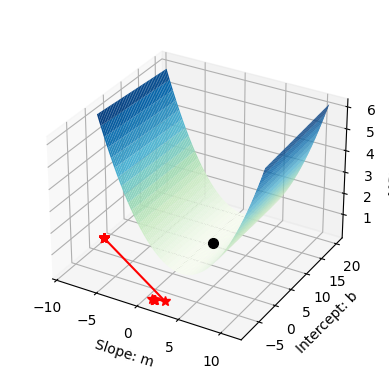

In [48]:
graph_linear_regression_mse(height,wingspan,trajectory= trajectory)

데이터의 산점도와 이상적인 선형 회귀 모델, 그리고 경사하강법을 통해 구한 선형 회귀 모델을 함께 나타내보겠습니다.

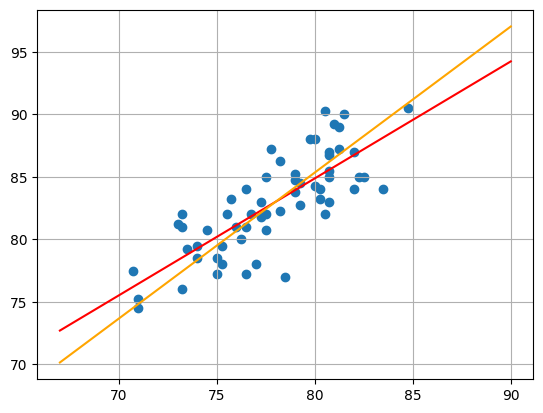

In [51]:
plt.scatter(height,wingspan)
plt.plot(x, m*x + b, c= 'red')
plt.plot(x, model.m.item()*x + model.b.item(), c= 'orange')
plt.grid()

> loss landscape 그래프를 그린 결과에서는 원래 스텝을 거듭할수록 검은색 점에 가까워지는 경로가 나타나야 하는데, $m$ 값은 잘 변화한 듯 하지만 $b$ 값은 초기의 값으로부터 크게 변화하지 못하면서 결국 검은색 점에 도달하지 못하는 경우가 발생할 수 있습니다. 산점도에서는 우리가 구한 모델이 이상적인 모델과는 다르며, 특히 y-절편 값이 이상적인 모델과 확연히 다름을 확인할 수 있습니다.

학습을 통해 구해진 모델이 초깃값에 얼마나 의존적인지 확인해보겠습니다. 동시에 여러 개의 모델을 생성하면 $m$, $b$의 초깃값들이 각각 다르게 설정될 것인데, 이 초깃값에 따라 얼마나 결과가 다르게 나타나는지를 loss landscape와 산점도로 시각화해보겠습니다. 먼저, 10개의 모델을 생성하고 학습 관련 변수를 설정하겠습니다.

In [52]:
num_models = 10
trajectory = [[]for i in range(num_models)]
models = [LinearModel() for i in range(num_models)]

num_epochs = 10
learning_rate = 1e-4

여러 개의 선형 모델을 학습시키고, 각 모델의 학습 경로(기울기와 절편의 변화)를 저장한 후 이를 시각화하겠습니다.

In [53]:
for n in range (num_epochs):
    for model_id, model in enumerate(models):
      y_pred = model(height_torch)
      loss = mean_squared_error(wingspan_torch, y_pred)
      loss.backward()
      trajectory[model_id].append((model.m.item(), model.b.item()))
      gradient_step(model.parameters, learning_rate)

<ipython-input-22-a488eb49ce51>:53: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='Slope: m', ylabel='Intercept: b', zlabel='MSE Loss'>)

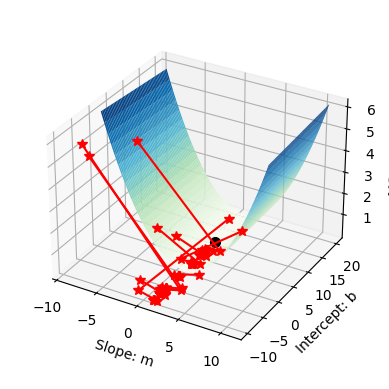

In [57]:
trajectoris = np.array(trajectory)
graph_linear_regression_mse(height, wingspan, trajectory=trajectoris)

각 모델의 학습된 직선을 데이터와 함께 플롯하고, Ordinary Least Squares (OLS) 방법으로 계산된 이상적인 직선도 함께 표시해보겠습니다.

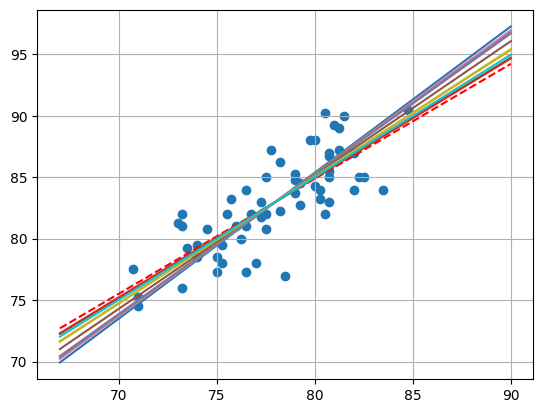

In [58]:
plt.scatter(height,wingspan)
plt.plot(x, m*x + b, c= 'red',ls = "--")
for n, model in enumerate(models):
  plt.plot(x, model.m.item()*x + model.b.item())
plt.grid()

> 초깃값에 따라 학습된 모델의 결과가 크게 달라짐을 확인해볼 수 있습니다.